In [1]:
# Copyright 2023 The Cirq Developers
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum utility

This colab contains code for simulating a circuit described in [1] on a subset
of qubits sufficient for reproducing the results in Fig. 4b. Running this simulation requires ~6GB of RAM, which may require a local runtime.
Additional RAM and/or compute cores can improve performance.

[1] Kim, Y., Eddins, A., Anand, S. et al. Evidence for the utility of quantum
computing before fault tolerance. Nature 618, 500–505 (2023).
https://doi.org/10.1038/s41586-023-06096-3

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

try:
    import qsimcirq
except ImportError:
    print("installing qsimcirq...")
    !pip install --quiet qsimcirq
    print(f"installed qsimcirq.")

In [3]:
import cirq
import qsimcirq
import matplotlib.pyplot as plt
import numpy as np
import sympy

In [4]:
# These 28 qubits construct the three "bricks" around qubit 62:
#
#           41-42-43-44-45
#           |           |
#           53          54
#           |           |
#     58-59-60-61-62-63-64-65-66
#     |           |           |
#     71          72          73
#     |           |           |
#     77-78-79-80-81-82-83-84-85
#
qubit_ids = [
    *range(41, 46),  # row 0
    *range(53, 55),  # row 1
    *range(58, 67),  # row 2
    *range(71, 74),  # row 3
    *range(77, 86),  # row 4
]
q = {i: cirq.NamedQubit(f'q{i}') for i in qubit_ids}
qubits = list(q.values())

# This parameter will be used to sweep over X rotation angles.
theta = sympy.Symbol('theta')
x_rotations = cirq.Moment(cirq.rx(theta).on_each(qubits))

# This is the ZZ(-pi/2) gate described in equation (2).
zz_pi_2 = cirq.ZZ ** -0.5

# Each of these moments performs ZZ interactions along
# 1/3 of the edges in the region, corresponding to the
# red, blue, and green edges in Fig. 1b.
zz_layer_1 = cirq.Moment(
    zz_pi_2(q[41], q[53]),
    zz_pi_2(q[43], q[44]),
    zz_pi_2(q[58], q[71]),
    zz_pi_2(q[59], q[60]),
    zz_pi_2(q[61], q[62]),
    zz_pi_2(q[63], q[64]),
    zz_pi_2(q[72], q[81]),
    zz_pi_2(q[73], q[85]),
    zz_pi_2(q[78], q[79]),
    zz_pi_2(q[83], q[84]),
)
zz_layer_2 = cirq.Moment(
    zz_pi_2(q[42], q[43]),
    zz_pi_2(q[44], q[45]),
    zz_pi_2(q[53], q[60]),
    zz_pi_2(q[54], q[64]),
    zz_pi_2(q[62], q[63]),
    zz_pi_2(q[65], q[66]),
    zz_pi_2(q[71], q[77]),
    zz_pi_2(q[79], q[80]),
    zz_pi_2(q[81], q[82]),
    zz_pi_2(q[84], q[85]),
)
zz_layer_3 = cirq.Moment(
    zz_pi_2(q[41], q[42]),
    zz_pi_2(q[45], q[54]),
    zz_pi_2(q[58], q[59]),
    zz_pi_2(q[60], q[61]),
    zz_pi_2(q[62], q[72]),
    zz_pi_2(q[64], q[65]),
    zz_pi_2(q[66], q[73]),
    zz_pi_2(q[77], q[78]),
    zz_pi_2(q[80], q[81]),
    zz_pi_2(q[82], q[83]),
)

# This circuit encapsulates a single "step", as shown
# in Fig. 1a.
step = cirq.FrozenCircuit(
    x_rotations,
    zz_layer_1,
    zz_layer_2,
    zz_layer_3,
)
# Uncomment this line to print the circuit diagram for
# a single step of the circuit.
# print(step)

In [5]:
# The circuit used to generate Fig. 4b consists of 20 steps.
# Changing "repetitions" here will adjust the number of steps simulated.
all_steps = cirq.CircuitOperation(step, repetitions=20)
circuit = cirq.Circuit(all_steps)

# This is the Z observable on qubit 62.
observables = [cirq.Z(q[62])]

# These are approximately the values of theta plotted for experimental values
# in Fig. 4b. Changing this list will adjust the simulation to test other
# theta values.
theta_values = [*np.linspace(0, 0.8, 9), 1, np.pi / 2]
params = cirq.Points(key="theta", points=theta_values)

# These options are used to tune qsim performance.
# On CPU, "cpu_threads" should be set to the number of cores available.
opt = qsimcirq.QSimOptions(max_fused_gate_size=4, cpu_threads=24)
# To use GPU instead, uncomment this line:
# opt = qsimcirq.QSimOptions(use_gpu=True, gpu_mode=1)
simulator = qsimcirq.QSimSimulator(qsim_options=opt)

In [6]:
%%time
# This will log after each value of theta is simulated. Its purpose is to
# give an indication of total runtime before all simulations finish.
results = []
for i, result in enumerate(simulator.simulate_expectation_values_sweep_iter(circuit, observables, params)):
    results.append(result)
    print(f"Completed theta={theta_values[i]:.3f}; value={result}")

# Runtimes logged in the output of this cell were achieved using a machine with
# 24 cores and 80GB of RAM.

Completed theta=0.000; value=[(1+0j)]
Completed theta=0.100; value=[(0.9957248494988796-1.0945159604072678e-09j)]
Completed theta=0.200; value=[(0.9785691808859784+5.244455029047104e-09j)]
Completed theta=0.300; value=[(0.9227771228638144+1.0042918680018413e-08j)]
Completed theta=0.400; value=[(0.8549387301071374-1.899016572015007e-10j)]
Completed theta=0.500; value=[(0.7790027681081058-6.695167987532044e-09j)]
Completed theta=0.600; value=[(0.6093954499261214-4.028657081304886e-09j)]
Completed theta=0.700; value=[(0.4257824480390532-1.4948143005177584e-10j)]
Completed theta=0.800; value=[(0.20900853480698267-9.495178461289215e-11j)]
Completed theta=1.000; value=[(0.011624567839324501+1.1215127671718956e-12j)]
Completed theta=1.571; value=[(-4.8872551798147e-09-6.909408682133451e-16j)]
CPU times: user 1h 25min 36s, sys: 38 s, total: 1h 26min 14s
Wall time: 3min 55s


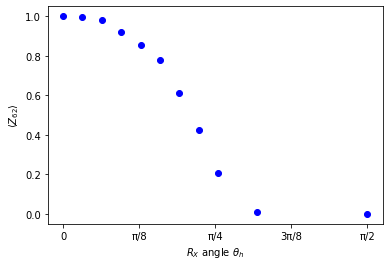

In [7]:
# Each element of "results" is a list of one expectation value (for Z[62]).
plot_results = [x[0].real for x in results]

# Plot the results in the format of Fig. 4b.
plt.plot(np.array(theta_values), plot_results, 'bo')
plt.xlabel(r"$ R_X $ angle $ \theta_h $")
plt.ylabel(r"$ \langle Z_{62} \rangle $")
plt.xticks(np.linspace(0, np.pi / 2, 5), ["0", "π/8", "π/4", "3π/8", "π/2"])
plt.yticks(np.linspace(0, 1, 6))
plt.show()